~ This is a kaggle Notebook

# **DeepFake Image Detection**
Implementing Research Paper "Towards Universal Fake Image Detectors that generalize Across Generative Models"

# **Unzipping the data**

Diffusion Models

In [2]:
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>
import zipfile
zip_file_path = '/content/drive/MyDrive/Copy of diffusion_datasets.zip'
extracted_dir = '/content/diffusion'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>

GAN Models

In [3]:
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>
import zipfile
zip_file_path = '/content/drive/MyDrive/Copy of CNN_synth_testset.zip'
extracted_dir = '/content/gan'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>

Checking availability of GPU

In [4]:
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>

CUDA is available. Using GPU.


**Importing the libraries**

In [1]:
#Importing the libraries
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>
import os
import numpy as np
from PIL import Image
import cv2
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>

# **Data Reading**
- Reading data from **ProGan** (Real and Fake Images) for **Training Phase**
- It iterate over each file and **Reads** the image using cv2.imread()
- It checks if the image is in **RGB Format** and appends the image if it satisfies this criterion
- Now we **Resize** the image into **(224,224,3)** dimensions

Use the below code to load images if you want to load the data from the unzipped file

In [60]:
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>
#Inititlaizing empty lists for storing images
real_img=[]
fake_img=[]
#path of folder to my training data
folders=os.listdir("/content/gan/progan")
os.chdir("/content/gan/progan")

#Iterating into each folder
for i in folders:
    content=os.listdir(i)  #contains ['0_real,'1_fake']

    path=os.path.join(i,content[0])
    subfld=os.listdir(path)  #contains list of all images
    for j in subfld:
        img_path=os.path.join(i,content[0],j)
        #Reading the image
        img=np.array(Image.open(img_path))
        #Checking if it is a RGB image
        if len(np.shape(img))==3:
            real_img.append(img)

    path=os.path.join(i,content[1])
    subfld=os.listdir(path)
    for j in subfld:
        img_path=os.path.join(i,content[1],j)
        #Reading the image
        img=np.array(Image.open(img_path))
        #Checking if it is a RGB Image
        if len(np.shape(img))==3:
            fake_img.append(img)
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>


Use the below code to load the dataset if you are loading the data from Goohle Drive

Change GDrive link with your link

In [7]:
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>
#Initializing empty lists for storing testing images
real_img=[]
fake_img=[]
#path of folder to my testing data
os.chdir("/content/drive/MyDrive/progan")
path="/content/drive/MyDrive/progan/1_fake"
l=os.listdir(path)
l=l[:1000]
#Iterating into each file
for j in l:
    #Reading the image
    img = cv2.imread(os.path.join(path,j))
    #Checking the image if its RGB
    if img is not None and len(img.shape) == 3:
        img_resized = cv2.resize(img, (224,224))
        fake_img.append(img_resized)
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>
path="/content/drive/MyDrive/progan/0_real"
l=os.listdir(path)
l=l[:1000]
for j in l:
    #Reading the image
    img = cv2.imread(os.path.join(path,j))
    #Checking if the image is in RGB format
    if img is not None and len(img.shape) == 3:
        img_resized = cv2.resize(img, (224,224))
        real_img.append(img_resized)
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>

In [8]:
print("Real Images:",np.shape(real_img))
print("Fake Images",np.shape(fake_img))

Real Images: (1000, 224, 224, 3)
Fake Images (1000, 224, 224, 3)


# **Pre-Processing of data**
- The following function preprocesses the data using :
    - 1) **JPEG Compression** : It converts the format of image to .jpg with 80% 
    - 2) **Gaussian Blur** :  It applies a gaussian blur filter with kernel size=(5,5) and std dev=0 to half of the images using np.random.rand()<0.5

In [61]:
def preprocess(orignal):
  #JPEG comppression
  encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), 80]
  _, comp = cv2.imencode('.jpg',orignal, encode_param)
  comp = cv2.imdecode(comp, 1)

  #Gaussian Blur
  if np.random.rand()<0.5:
    kernel_size = (5, 5)
    blurred_image = cv2.GaussianBlur(orignal, kernel_size, 0)
    return blurred_image
  else:
    return comp

Showing the effect of preprocessing to any random image

In [62]:
#Showing the effect of preprocessing to any random image
image_to_show=cv2.imread("/content/drive/MyDrive/biggan/0_real/0--n01440764_5043.png")
image_preprocessed=preprocess(image_to_show)

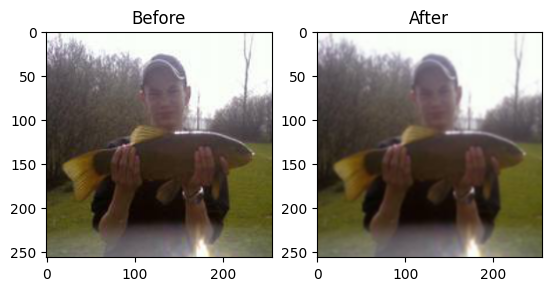

In [63]:
#Plotting the orignal and preprocessed image
import cv2
import matplotlib.pyplot as plt
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image_to_show,cv2.COLOR_BGR2RGB))
plt.title("Before")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image_preprocessed,cv2.COLOR_BGR2RGB))
plt.title("After")
plt.show()

Applying preprocessing to real images

In [12]:
real=[preprocess(i) for i in real_img]
np.shape(real)

(1000, 224, 224, 3)

Applying preprocessing to fake images

In [13]:
fake=[preprocess(i) for i in fake_img]
np.shape(fake)

(1000, 224, 224, 3)

# **Testing Data**
- Reading data for **Testing Phase**
- It iterate over each file and **Reads** the image using cv2.imread()
- It checks if the image is in **RGB Format** and appends the image if it satisfies this criterion
- Now we **Resize** the image into **(224,224,3)** dimensions

In [14]:
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>
#Initializing empty lists for storing testing images
r_t=[]
f_t=[]
#path of folder to my testing data
os.chdir("/content/diffusion/diffusion_datasets")
path="/content/diffusion/diffusion_datasets/dalle/1_fake"
l=os.listdir(path)
#Iterating into each file
for j in l:
    #Reading the image
    img = cv2.imread(os.path.join(path,j))
    #Checking the image if its RGB
    if img is not None and len(img.shape) == 3:
        img_resized = cv2.resize(img, (224,224))
        f_t.append(img_resized)
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>
path="/content/diffusion/diffusion_datasets/laion/0_real"
l=os.listdir(path)
for j in l:
    #Reading the image
    img = cv2.imread(os.path.join(path,j))
    #Checking if the image is in RGB format
    if img is not None and len(img.shape) == 3:
        img_resized = cv2.resize(img, (224,224))
        r_t.append(img_resized)
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>

In [15]:
#Slicing and taking first 500 images from each real and fake set of images
r_tt=r_t[:500]
f_tt=f_t[:500]
np.shape(f_tt)

(500, 224, 224, 3)

In [16]:
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>
test_images=np.concatenate([r_tt,f_tt])

test_labels=[0]*500
test_labels.extend([1]*500)

print("Testing images:\n",np.shape(test_images))
print(np.shape(test_labels))
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>

Testing images:
 (1000, 224, 224, 3)
(1000,)


Applying preprocessing to the testing images

In [17]:
test=[preprocess(i) for i in test_images]
print(np.shape(test))
print(np.shape(test_labels))

(1000, 224, 224, 3)
(1000,)


# **Importing CLIP Model from OpenAI Github Repository**

Repo Link:https://github.com/openai/CLIP.git

In [18]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 2.4 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-lm7t36xf
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-lm7t36xf
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=c18fccbffbdefaf1a9e21563aa2cb751363256f0a517cb4b3ed2008dc6a060d3
  Stored in directory: /tmp/pip-ephem-wheel-cache-e197i8mp/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


Taking CLIP model from Transformers
(tried using this method to import clip model , but it was not working)

In [ ]:
# from transformers import CLIPProcessor, CLIPModel
# import torch

# processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")
# model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")

# **Importing the libraries**

In [19]:
import torch
from pkg_resources import packaging
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split

**Finding "ViT-L/14" model from CLIP**

In [20]:
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>
import clip
for i in clip.available_models():
  if i=="ViT-L/14":
      print("Model Found")
      break
  else:
    print("Searching...")
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>

Searching...
Searching...
Searching...
Searching...
Searching...
Searching...
Searching...
Model Found


Loading the model imported above with all its parameters

In [21]:
model, preprocess_model = clip.load("ViT-L/14")
model.cuda().eval()

100%|███████████████████████████████████████| 890M/890M [00:10<00:00, 89.4MiB/s]


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
    (ln_pre): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
          )
          (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=1024, out_features=4096, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=4096, out_features=1024, bias=True)
          )
          (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)


**Preprocessing** the data from the **preprocess function of Clip model**

In [22]:
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>
real_t=[]
#Iterating into each image
for i in range(len(real)):
  #Loading image
  temp=Image.fromarray(real[i])
  #Applying preprocessing function
  real_t.append(preprocess_model(temp))
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>

In [23]:
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>
fake_t=[]
#Iterating into each image
for i in range(len(fake)):
  #Loading image
  temp=Image.fromarray(fake[i])
  #Applying preprocessing function
  fake_t.append(preprocess_model(temp))
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>

In [24]:
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>
test_t=[]
#Iterating into each image
for i in range(len(test)):
  #Loading image
  temp=Image.fromarray(test[i])
  #Applying preprocessing function
  test_t.append(preprocess_model(temp))
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>

**Stacking** all the images together and **converting** into **tensor format** using cuda

In [25]:
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>
real_tr=torch.tensor(np.stack(real_t)).cuda()
fake_tr=torch.tensor(np.stack(fake_t)).cuda()
test_tr=torch.tensor(np.stack(test_t)).cuda()
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>

# **Encoding of Images into Feature Vectors**
- Firstly it checks if GPU is available using torch.cuda.is_available(). If available, the device is set to CUDA (GPU); otherwise, it falls back to CPU.
- The feature extraction process is performed on the image tensor using the CLIP model (model.encode_image()) with the with torch.no_grad() context manager to disable gradient tracking, as feature extraction does not require gradients.

Encoding for real Images

In [26]:
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>
#Using GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model = model.to(device)
real_tr = real_tr.to(device)
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>
#Encoding the image into its feature vector(1*786) using Clip Model 
with torch.no_grad():
    features_real = model.encode_image(real_tr).float()
features_real.shape
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>


torch.Size([1000, 768])

Encoding for fake images

In [27]:
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>
#using GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
fake_tr = fake_tr.to(device)
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>
#Encoding the image into its feature vector(1*786) using Clip Model 
with torch.no_grad():
    features_fake = model.encode_image(fake_tr).float()
features_fake.shape
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>


torch.Size([1000, 768])

Encoding for testing images

In [28]:
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>
#Using GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
test_tr = test_tr.to(device)
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>
#Encoding the image into its feature vector(1*786) using Clip Model 
with torch.no_grad():
    features_test = model.encode_image(test_tr).float()
features_test.shape
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>


torch.Size([1000, 768])

**Saving** the **Encoded Images** in tensor format in a **.pt file**

In [71]:
torch.save(features_real, "/content/drive/MyDrive/real.pt")
torch.save(features_fake, "/content/drive/MyDrive/fake.pt")
torch.save(features_test, "/content/drive/MyDrive/test_dm.pt")

# **Loading the encoded images**

In [5]:
features_fake=torch.load("/content/drive/MyDrive/Data/real.pt") #Real
features_real=torch.load("/content/drive/MyDrive/Data/fake.pt") #Fake

**Converting** them to **numpy format** from tensors

In [6]:
features_real=features_real.cpu().numpy()
features_fake=features_fake.cpu().numpy()

# **Plots**
**Plotting a T-SNE plot for both real and fake images of ProGan Dataset**

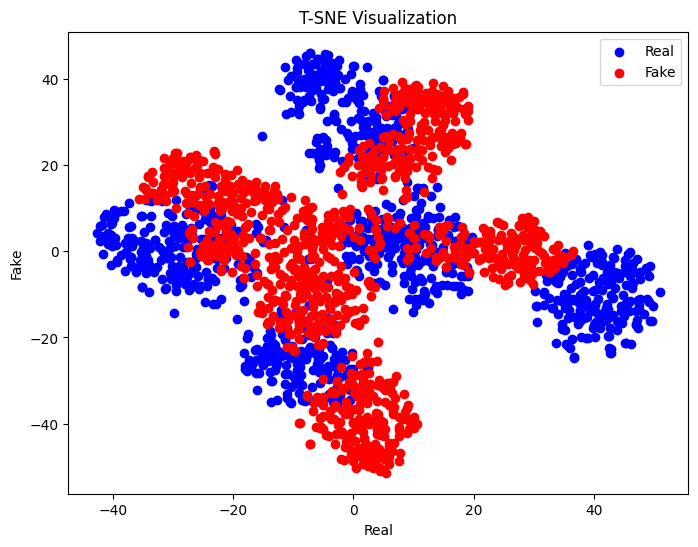

In [83]:
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>
#Importing Libraries
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>
#Reducing the dimensionality
tsne=TSNE(n_components=2, random_state=40)
t1_p=tsne.fit_transform(features_real)
t2_p=tsne.fit_transform(features_fake)
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>
#Plotting them
plt.figure(figsize=(8, 6))
plt.scatter(t1_p[:, 0], t1_p[:, 1], color='blue', label='Real')
plt.scatter(t2_p[:, 0], t2_p[:, 1], color='red', label='Fake')
plt.legend()
plt.title('T-SNE Visualization')
plt.xlabel('Real')
plt.ylabel('Fake')
plt.show()
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>

# **Implementing Nearest Neighbor Approach**

**Funcion**:
- It finds the nearest neighbor to a given test feature vector among a set of feature vectors using cosine similarity.

**Parameters**:
- test: The test feature vector for which the nearest neighbor is to be found.
- features: A 2D array containing feature vectors among which to find the nearest neighbor.

**Returns**:
- nn_sim: The cosine similarity between the test feature vector and its nearest neighbor.

In [7]:
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>
from sklearn.metrics.pairwise import cosine_similarity
def find_nn(test,features):
    cos_sim=cosine_similarity(features, [test])
    nn_ind=np.argmax(cos_sim)
    n_nbg = features[nn_ind]
    nn_sim = cos_sim[nn_ind][0]
    return nn_sim
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>

# **Testing Phase**
- After training on ProGan now I am testing on **Glide-100** and **Laion**
- The **test.pt** file is loaded and converted to a NumPy array (which contains Images from **Glide** and **Laion**)
- A loop iterates over each feature vector in features_test.
    - For each feature vector, the nearest neighbors are found in both the real and fake feature sets using the find_nn() function.
    - That class which has less cosine similarity which means it is more closer to test image is assigned to the test image 

In [24]:
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>
#Loading the data
features_test = torch.load("/content/drive/MyDrive/Data/test.pt")
#Converting into Numpy array
features_test=features_test.cpu().numpy()
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>
#A List to store the predicted class
predicted=[]
for j in features_test:
    real_nn=find_nn(j,features_real)
    fake_nn=find_nn(j,features_fake)

    if real_nn>fake_nn: 
      predicted.append(1)
    else:
      predicted.append(0)
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>

Calculating accuracy

In [25]:
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>
test_labels=np.concatenate([[0]*500,[1]*500])
c=0
for i in range(len(test_labels)):
    if(predicted[i]==test_labels[i]):
      c=c+1
print("Accuracy:")
(c/len(test_labels))*100
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>

Accuracy:


75.2

# **Implementing Linear Classification Approach**

For **Linear Classification**, I am training a neural network using TensorFlow's Keras API **(FCNN network)**

1. **Data Preparation**: `features_real` and `features_fake` are concatenated into `X_train`and corresponding labels `Y_train` are defined. Then both are converted into numpy arrays

2. **Hyperparameters**: 
    - **Batch Size:** 30 (as instructed in the research paper)
    - **Epochs:** 7 (The model acheives a training accuracy of 1 so trained on less no of epochs)

3. **Model Structure**: It consists of two fully connected layers: 
    - First layer has 768 units and uses the ReLU activation function.
    - Output layer has 1 unit with a sigmoid activation function, for binary classification problems.

4. **Model Compilation**: The model is compiled using the Adam optimizer and binary crossentropy loss function. 
    - Used **Adam** as optimizer
    - Used **Binary crossentropy loss** as Loss Function


# **Training Phase**

In [3]:
#importing libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [119]:
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>
#Preparing data
X_train=np.concatenate([features_real,features_fake])
Y_train=[0]*len(features_real)
Y_train.extend([1]*len(features_test))
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>
#Converting into numpy format
X_train=np.array(X_train)
Y_train=np.array(Y_train)
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>

In [120]:
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>
#Hyperparameters
batch_size=30
epochs=7
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>
#model structure
model_lc = Sequential()
model_lc.add(Dense(units=768, input_shape=(768,), activation='relu'))
model_lc.add(Dense(units=1, activation='sigmoid'))
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>
#Training the model
model_lc.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_lc.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size)
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>

Epoch 1/7
67/67 [==============================] - 1s 3ms/step - loss: 0.1905 - accuracy: 0.9150
Epoch 2/7
67/67 [==============================] - 0s 3ms/step - loss: 0.0491 - accuracy: 0.9840
Epoch 3/7
67/67 [==============================] - 0s 3ms/step - loss: 0.0220 - accuracy: 0.9960
Epoch 4/7
67/67 [==============================] - 0s 3ms/step - loss: 0.0161 - accuracy: 0.9975
Epoch 5/7
67/67 [==============================] - 0s 4ms/step - loss: 0.0065 - accuracy: 1.0000
Epoch 6/7
67/67 [==============================] - 0s 3ms/step - loss: 0.0029 - accuracy: 1.0000
Epoch 7/7
67/67 [==============================] - 0s 3ms/step - loss: 0.0019 - accuracy: 1.0000


# **Testing Phase**
- Firstly we load the saved tensors
- Then convert them to nunpy format
- Then calculate the accuracy using the model above

1. **Cycle GAN**

In [136]:
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>
#Loading data
features_test=torch.load("/content/drive/MyDrive/test_cg.pt")
#Converting into tensor format
features_test=features_test.cpu().numpy()
#Test labels
test_labels=np.concatenate([[0]*500,[1]*500])
X_test=np.array(features_test)
Y_labels=np.array(test_labels)
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>
#Testing
print("Accuracy:")
model_lc.evaluate(X_test,Y_labels)[1]
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>

Accuracy:
32/32 [==============================] - 0s 3ms/step - loss: 0.0824 - accuracy: 0.9730


0.9729999899864197

2. **Dalle-100 and Laion**

In [135]:
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>
#Loading data
features_test=torch.load("/content/drive/MyDrive/test_dm.pt")
features_test=features_test.cpu().numpy()
test_labels=np.concatenate([[0]*500,[1]*500])
X_test=np.array(features_test)
Y_labels=np.array(test_labels)
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>
#Testing phase
print("Accuracy:")
model_lc.evaluate(X_test,Y_labels)[1]
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>

Accuracy:
32/32 [==============================] - 0s 2ms/step - loss: 0.4469 - accuracy: 0.8690


0.8690000176429749

3. **Glide-100 and Laion**

In [130]:
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>
#Loading data
features_test=torch.load("/content/drive/MyDrive/Data/test1.pt")
features_test=features_test.cpu().numpy()
test_labels=np.concatenate([[1]*500,[0]*500])
X_test=np.array(features_test[:1000])
Y_labels=np.array(test_labels)
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>
# Testing phase
print("Accuracy:")
model_lc.evaluate(X_test,Y_labels)[1]
#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------>

Accuracy:
32/32 [==============================] - 0s 2ms/step - loss: 0.2380 - accuracy: 0.9290


0.9290000200271606